In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 30.3 MB/s eta 0:00:00


In [2]:
# Import the necessary modules and libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # set the variable to the device available

In [4]:
# Downloaded the MNIST dataset from PyTorch inbuilt datasets
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                                        train=True, 
                                                        transform=transforms.ToTensor(), 
                                                        download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=False, 
                                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Created a custom train dataset
class MNIST_Sum_Train_Dataset(Dataset):
    """

    A custom train dataset which pairs the MNIST dataset with random numbers and gives out data in the way we want.
  
    """
    def __init__(self):
      super(MNIST_Sum_Train_Dataset, self).__init__()
      self.MNIST = torchvision.datasets.MNIST(root='./data', 
                                                      train=True, 
                                                      transform=transforms.ToTensor(), 
                                                      download=True)
        
    def __len__(self):
        """
        Returns the length of our custom dataset which is the same as the length of MNIST dataset.
        """
        return len(self.MNIST)

    def __getitem__(self, idx):
        """
      
        Parameters:
        idx (int): index
      
        Returns:
        4 element tuple:
          img - image at the idx index of MNIST dataset
          img_label - label of img
          random_second - a random number generated of shape (1,1) in range 0 to 9
          sum_label - sum of img_label and random_second

        """
        img, img_label = self.MNIST[idx]
        random_second = torch.randint(0, 10, (1,1))
        sum_label = (random_second + img_label).item()
        return img, img_label, random_second, sum_label

In [6]:
class MNIST_Sum_Test_Dataset(Dataset):
    """
    A custom test dataset made in a similar fashion. 
    """
    def __init__(self):
      super(MNIST_Sum_Test_Dataset, self).__init__()
      self.MNIST = torchvision.datasets.MNIST(root='./data', 
                                                      train=False, 
                                                      transform=transforms.ToTensor(), 
                                                      download=True)
        
    def __len__(self):
        return len(self.MNIST)

    def __getitem__(self, idx):
        img, img_label = self.MNIST[idx]
        random_second = torch.randint(0, 10, (1,1))
        sum_label = (random_second + img_label).item()
        return img, img_label, random_second, sum_label

In [7]:
train_data = MNIST_Sum_Train_Dataset()
test_data = MNIST_Sum_Test_Dataset()
print(len(train_data))
print(len(test_data))
kwargs = {'num_workers': 4, 'pin_memory': True} if device=='cuda' else {}
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True, **kwargs)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True, **kwargs)
print(len(test_dataset))
for i in train_loader:
  print(i[0][0].size())
  break

60000
10000
10000
torch.Size([1, 28, 28])


digits tensor([0, 0, 4, 3, 4, 7, 3, 0, 3, 1, 2, 2, 3, 3, 6, 2, 7, 8, 4, 5, 3, 6, 0, 2,
        2, 3, 9, 9, 9, 0, 3, 9])
random numbers: tensor([2, 6, 2, 8, 6, 0, 6, 2, 0, 2, 5, 7, 9, 3, 8, 0, 8, 5, 1, 4, 7, 4, 2, 9,
        1, 6, 2, 1, 9, 4, 7, 8])
sum labels: tensor([ 2,  6,  6, 11, 10,  7,  9,  2,  3,  3,  7,  9, 12,  6, 14,  2, 15, 13,
         5,  9, 10, 10,  2, 11,  3,  9, 11, 10, 18,  4, 10, 17])


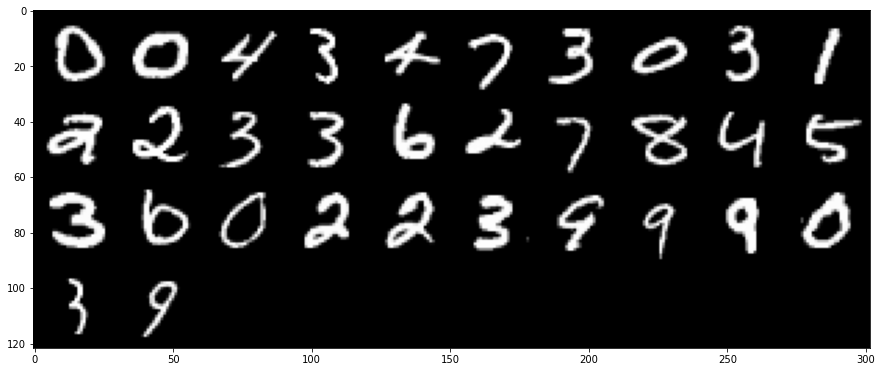

In [9]:
batch = next(iter(train_loader))
imgs, img_labels, random_seconds, sum_labels = batch
grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('digits', img_labels)
print('random numbers:', random_seconds.reshape(-1))
print('sum labels:', sum_labels)

In [11]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # input - (1,28,28) RF = 1
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3)       #output - (32, 26, 26)   RF = 3
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3)      #output - (64, 24, 24)   RF = 5
    self.pool1 = nn.MaxPool2d(kernel_size=2)                                        #output - (64, 12, 12)   RF = 10
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3)     #output - (128, 10, 10)  RF = 12
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3)    #output - (256, 8, 8)    RF = 14
    self.pool2 = nn.MaxPool2d(kernel_size=2)                                        #output - (256, 4, 4)    RF = 28
    self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3)    #output - (512, 2, 2)    RF = 30
    #Flatten the output and concat the random second number to it
    self.fc1 = nn.Linear(in_features = ((512*2*2) + 1), out_features = 512)
    self.fc2 = nn.Linear(in_features = 512, out_features = 10)
    self.fc3 = nn.Linear(in_features = 512, out_features = 19)

  def forward(self, img, random_second):
    x = self.conv1(img)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv5(x)
    x = F.relu(x)
    x = x.reshape(-1, 1, 512*2*2)     #Flattened the output
    new_x = torch.cat((x, random_second), dim=2)         #Concatenated the random second number to the flattened vector
    new_x = self.fc1(new_x)
    digit = self.fc2(new_x)
    digit = digit.reshape(-1, 10)    #The embedding for the prediction of digit
    sum = self.fc3(new_x)
    sum = sum.reshape(-1, 19)        #The embedding for the prediction of sum
    return digit, sum



In [12]:
model = Network()      # Initiated the model
loss = nn.CrossEntropyLoss()      # Used the Cross Entropy loss function
optimizer = optim.Adam(model.parameters(), lr = 0.001)     # Initialized the Adam optimizer
model.to(device = device)     # Transferred the model to the GPU
loss.to(device = device)      # Transferred the loss to the GPU
num_epochs = 10

model.train()        # Set the mode of the model to "train"
for i in range(num_epochs):
  TL = 0            # Initialized the Total Loss so that we can print loss after each epoch
  for data in train_loader:
    optimizer.zero_grad()      # Zeroed out the gradients
    img, img_label, random_second, label = data[0].to(device = device), data[1].to(device = device), data[2].to(device = device), data[3].to(device = device)     # Transferred the current data to the GPU
    digit, sum = model(img, random_second)     # Forward Pass
    loss1 = loss(digit, img_label)        # Calculated loss of first task
    loss2 = loss(sum, label)              # Calculated loss of second task
    total_loss = loss1 + loss2
    total_loss.backward()       # Backward Pass
    optimizer.step()          # Took a step of Adam Gradient Descent
    TL += total_loss
  print(TL.item())         # Printed the total loss

2864.595947265625
1731.0958251953125
1353.850830078125
1108.0623779296875
939.68994140625
767.0390625
691.0716552734375
584.0015258789062
497.2879943847656
466.79229736328125


In [31]:
model.eval()         # Set the mode of the model to "eval" so that it does not do unnecessary calculations like calculating gradients
Total_Accuracy_Digit = 0        # Initialized the Total Loss of Digit Prediction so that we can print loss after the evaluation
Total_Accuracy_Sum = 0          # Initialized the Total Loss of Sum Prediction so that we can print loss after the evaluation
Num_examples = 0      # A variable to calculate the number of examples
accuracy_digit = Accuracy(task="multiclass", num_classes=10)         # Initialized the accuracy metric for Digit Prediction
accuracy_sum = Accuracy(task="multiclass", num_classes=19)           # Initialized the accuracy metric for Sum Prediction
accuracy_digit.to(device)
accuracy_sum.to(device)     # Transferred both the metrics to the GPU
for data in test_loader:
  img, img_label, random_second, label = data[0].to(device = device), data[1].to(device = device), data[2].to(device = device), data[3].to(device = device)
  digit, sum = model(img, random_second)
  digit = torch.argmax(digit, dim=1)       # Found the preds from probabilities
  sum = torch.argmax(sum, dim=1)           # Found the preds from probabilities
  Curr_Accuracy_Digit = accuracy_digit(digit, img_label).item()*100
  Curr_Accuracy_Sum = accuracy_sum(sum, label).item()*100                # Calculated the accuracies
  Total_Accuracy_Digit += Curr_Accuracy_Digit*(digit.size()[0])
  Total_Accuracy_Sum += Curr_Accuracy_Sum*(digit.size()[0])
  Num_examples += digit.size()[0]
  print("Digit Accuracy :", Curr_Accuracy_Digit, "Sum Accuracy :", Curr_Accuracy_Sum)

Total_Accuracy_Digit /= Num_examples
Total_Accuracy_Sum /= Num_examples

print()
print()
print("Total Digit Accuracy :", Total_Accuracy_Digit)
print("Total Sum Accuracy :", Total_Accuracy_Sum)

Digit Accuracy : 100.0 Sum Accuracy : 84.375
Digit Accuracy : 96.875 Sum Accuracy : 90.625
Digit Accuracy : 100.0 Sum Accuracy : 93.75
Digit Accuracy : 100.0 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 100.0
Digit Accuracy : 100.0 Sum Accuracy : 90.625
Digit Accuracy : 96.875 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 100.0
Digit Accuracy : 100.0 Sum Accuracy : 93.75
Digit Accuracy : 96.875 Sum Accuracy : 87.5
Digit Accuracy : 96.875 Sum Accuracy : 90.625
Digit Accuracy : 100.0 Sum Accuracy : 100.0
Digit Accuracy : 96.875 Sum Accuracy : 93.75
Digit Accuracy : 100.0 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 90.625
Digit Accuracy : 96.875 Sum Accuracy : 90.625
Digit Accuracy : 96.875 Sum Accuracy : 96.875
Digit Accuracy : 96.875 Sum Accuracy : 96.875
Digit Accuracy : 100.0 Sum Accuracy : 90.625
Digit Accuracy : 100.0 Sum Accuracy : 96.875
Digit Accu